### Import

In [1]:
#1_merge_csv.ipynb
import os
import glob
import pandas as pd

#2_DataPrep.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import time
import os

#3_Descriptive.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import time
import os
import matplotlib

#4_translate.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import time
import os
from translate import Translator

#5_Network DataPrep.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import collections
import community
import networkx as nx 
from netwulf import visualize

#6_BigramsNetwork.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import itertools
import collections
import re
import time
import community
import os
import nltk
from nltk import bigrams
import networkx as nx
from nltk.corpus import stopwords
#nltk.download('stopwords')
from stop_words import get_stop_words

#7_Sentiment.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import time
import os
#from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#8_Prediction.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import re
import sklearn as skl
from sklearn.linear_model import Lasso, LinearRegression
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# 1_merge_csv

In [ ]:
#os.chdir("TwitterData")

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

# 2_DataPrep

In [21]:
#open the raw data
rawdata = pd.read_csv('combined_csv.csv', ",")

#merge politician party
partier = pd.read_csv('Partier.csv', ",")
data = rawdata.merge(partier, how='left' ,left_on= 'Account', right_on ='Navn')

#rename columns
data = data.rename(index=str, columns={'User Name':"User_Name", 'Followers at Posting':'Followers', 'Screen Name': 'Screen_Name', 'Link 1': 'Link_1', 'Final Link 1': 'Final_Link_1', 'Link 2': 'Link_2', 'Final Link 2': 'Final_Link_2'})

#correct two random named accounts
data.loc[data['User_Name'] == 'LiseBech', 'Parti'] = "DF"
data.loc[data['User_Name'] == 'renegadedreng', 'Parti'] = "A"
data.loc[data['User_Name'] == 'sfhoni', 'Parti'] = "SF"

#check for missing values
#mis = data[data['Parti'].isnull()]

partierblok = pd.read_csv('PartierBlokke.csv', ";")
data = data.merge(partierblok, how='left' ,left_on= 'Parti', right_on ='Parti')
data = data.drop(columns=['Parti'])
data = data.rename(index=str, columns={"Parti_ny": "Parti"})

In [22]:
# create a dummy indicating party-accounts
data['Account_Type'] = 0  

data.loc[data['Account'] == 'Venstre', 'Account_Type'] = 1
data.loc[data['Account'] == 'Enhedslisten', 'Account_Type'] = 1
data.loc[data['Account'] == 'SF', 'Account_Type'] = 1
data.loc[data['Account'] == 'Radikale Venstre', 'Account_Type'] = 1
data.loc[data['Account'] == 'Socialdemokratiet', 'Account_Type'] = 1

In [23]:
# dato
data['Date_Temp'] = data.Created.apply(lambda x: x[0:-4])
data['Date'] = pd.to_datetime(data.Date_Temp.str.strip(), format = '%Y-%m-%d %H:%M:%S')
data = data.drop(['Created', 'Date_Temp'], axis=1)
data['Ymd'] = data.Date.apply(lambda x: x.date())

In [25]:
#Create a dummy indicating whether the tweet is a re-tweet
data['Msgfrst2'] = data.Message.apply(lambda x: x[0:2])
data['Retweet_WOC'] = np.where(data['Msgfrst2']=='RT', 1, 0)
data = data.drop(columns=['Msgfrst2'])

In [26]:
#Create a dymme indicating wheather the tweet beings with "@" and is thereby a comment
data['Msgfrst3'] = data.Message.apply(lambda x: x[0:1])
data['Comment'] = np.where(data['Msgfrst3']=='@', 1, 0)
data = data.drop(columns=['Msgfrst3'])

In [27]:
#replace missing values with 0 in order to run loop
data.loc[pd.isnull(data['Link_1']), 'Link_1'] = "No_Link"

In [28]:
# Create a dummy for re-tweets with comments
Retweet_WC = []
count_ = 0
for i in range(len(data)):

    if 'https://twitter.com' in data['Link_1'][i] and data['Retweet_WOC'][i] ==0 and data['Comment'][i] ==0:
        count_ = count_ + 1
        Retweet_WC.append(1)
            
    else:
        Retweet_WC.append(0)
count_

1685

In [30]:
#Append new variable to dataset
data['Retweet_WC'] = pd.DataFrame(Retweet_WC, index = data.index )

In [32]:
rt_woc = data['Retweet_WOC'].value_counts()
rt_wc = data['Retweet_WC'].value_counts()
comments = data['Comment'].value_counts()

print(rt_woc)
print(rt_wc)
print(comments)

In [37]:
data.to_csv('data.csv', index=False, sep = ',')

# 3_Descriptive

In [55]:
data = pd.read_csv('data.csv', ",")

In [57]:
#Total activities per party
parti_count = data['Parti'].value_counts()
parti_count

A    5700
V    3556
Ø    3365
Å    2881
O    2599
F    2514
I    2383
B    1820
C    1571
Name: Parti, dtype: int64

In [58]:
# antal twitterprofiler per parti
Member_Count = data.groupby('Parti').Account.nunique()
Member_Count = pd.DataFrame(Member_Count)
Member_Count

,Account
Parti,
A,34
B,9
C,8
F,8
I,12
O,20
V,27
Å,10
Ø,13


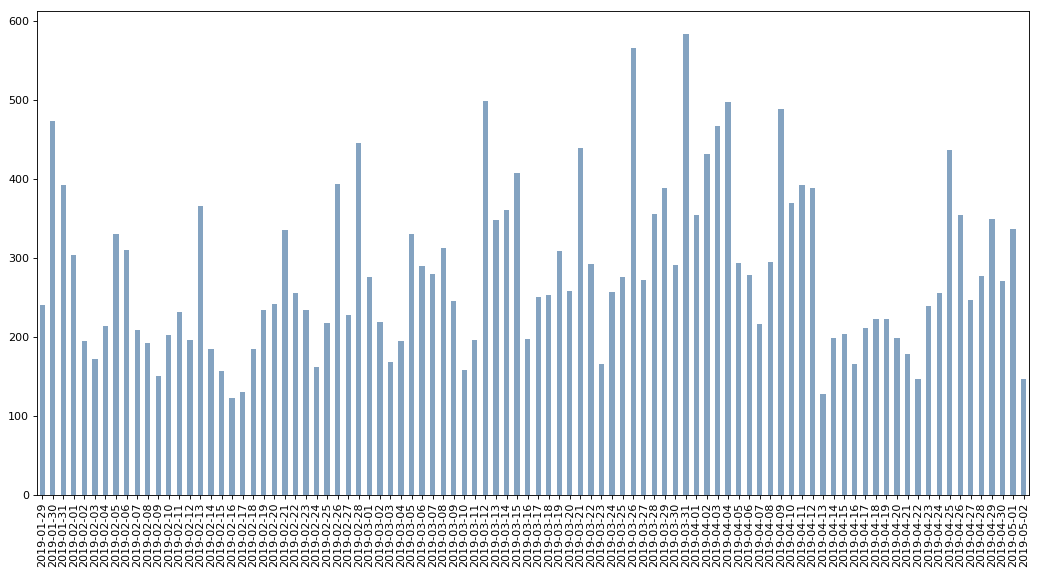

In [59]:
#Activities over time
Ymd_Count = pd.Series(data.Ymd).value_counts()
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
Ymd_Count.sort_index().plot.bar(color=(0.2, 0.4, 0.6, 0.6))

In [60]:
#Avg. activity per parti member
# Antal twets per partimedlem inklusiv parti-account
temp = data.groupby(["Parti", "Account"]).size().reset_index(name="Count")
Avg_Act = (temp.groupby(['Parti', 'Account'], as_index=False).mean().groupby('Parti')['Count'].mean())
Avg_Act

Parti
A    167.647059
B    202.222222
C    196.375000
F    314.250000
I    198.583333
O    129.950000
V    131.703704
Å    288.100000
Ø    258.846154
Name: Count, dtype: float64

In [61]:
data.head(1)

,Account,User_Name,Followers,Type,Likes,Retweets,URL,Message,Screen_Name,Link_1,...,Blok,Parti,Parti_tal,Parti_farve,Account_Type,Date,Ymd,Retweet_WOC,Comment,Retweet_WC
0,Hans Kristian Skibby,Hans_Kr_Skibby,2088.0,Tweet,27,14,https://twitter.com/Hans_Kr_Skibby/status/1123...,RT @SusieJessen: I dag klokken 10.15 er justit...,Hans_Kr_Skibby,No_Link,...,blue,O,3,#FBD000,0,2019-05-02 09:12:19,2019-05-02,1,0,0


In [62]:
RT_WOC_mean = (data.groupby(['Parti', 'Account'], as_index=False).mean().groupby('Parti')['Retweet_WOC'].mean())

In [63]:
RT_WC_mean = (data.groupby(['Parti', 'Account'], as_index=False).mean().groupby('Parti')['Retweet_WC'].mean())

In [64]:
COM_mean = (data.groupby(['Parti', 'Account'], as_index=False).mean().groupby('Parti')['Comment'].mean())

In [65]:
T_mean = 1 - (RT_WOC_mean+RT_WC_mean+COM_mean)

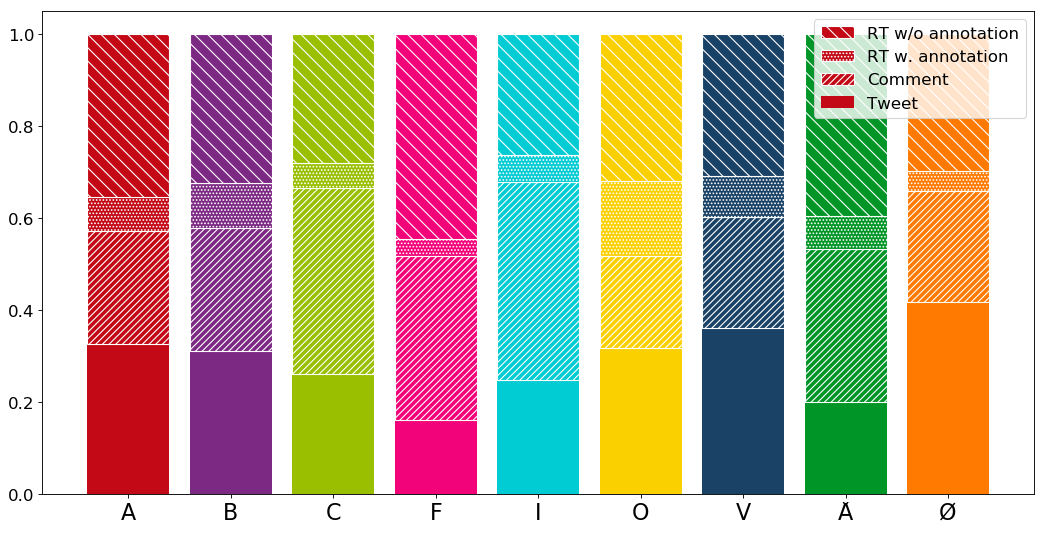

In [101]:
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=15)

figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

x_parti, y_RT_WOC = zip(*RT_WOC_mean.items())
y_RT_WOC = np.array(y_RT_WOC)
x_parti, y_RT_WC = zip(*RT_WC_mean.items())
y_RT_WC = np.array(y_RT_WC)
x_parti, y_COM = zip(*COM_mean.items())
y_COM = np.array(y_COM)
x_parti, y_T = zip(*T_mean.items())
y_T = np.array(y_T)

Color_Parti = ('#C30915','#7C2984','#99BF00','#F30379','#01CBD3','#FBD000','#194266','#009527','#FF7A00')

bottom1 = (y_T+y_COM)

p1 = plt.bar(x_parti, y_T, color = Color_Parti)
p2 = plt.bar(x_parti, y_COM, bottom=y_T, color = Color_Parti, hatch = '////', edgecolor = 'white', linewidth = '1')
p3 = plt.bar(x_parti, y_RT_WC, bottom=y_T+y_COM, color = Color_Parti, hatch = '....', edgecolor = 'white', linewidth = '1')
p4 = plt.bar(x_parti, y_RT_WOC, bottom=y_T+y_COM+y_RT_WC, color = Color_Parti, hatch = '\\\\', edgecolor = 'white', linewidth = '1')


#plt.title('Activity Shares')
plt.xticks(x_parti)
plt.legend((p4[0], p3[0], p2[0], p1[0]), ('RT w/o annotation', 'RT w. annotation', 'Comment','Tweet'),prop={'size': 15})

plt.show()


# 4_translate

In [446]:
# reading test2.csv
df = pd.read_csv('test2.csv', ",")
#df

In [447]:
# cleaning and preparing data for translation
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
def step1(temp):
    temp = re.sub(r'RT \@(.*: )', '__RT__ ', temp)
    temp = re.sub(r'https?:\/\/.([^\s]+)', '__link__ ', temp)
    temp = re.sub(r'@\S*\s?', '__profile__ ', temp)
    temp = RE_EMOJI.sub(r'__emoji__ ', temp)
    temp = re.sub(r'\S+@\S+', '__email__ ', temp)
    temp = re.sub(r'\S*…\S*?', ' __ending__ ', temp)
    #temp = re.sub(r'#\S*\s?', ' __hashtag__ ', temp) #outcommented due to keyword extraction
    temp = re.sub(r'(24:00|2[0-3]:[0-5][0-9]|[0-1][0-9]:[0-5][0-9])', "__time__ ", temp)
    temp = re.sub('  ', ' ', temp)
    return temp
df['text'] = df.Message.apply(lambda x: step1(x))

In [468]:
# splitting data into 3 sets
df['text_len'] = df.text.apply(lambda x: len(x))
df['text_sum'] = df.text_len.cumsum()

data_1 = df.iloc[0:10000]
data_2 = df.iloc[10000:20000]
data_3 = df.iloc[20000:]

#data_1.to_csv('data_1.csv')
#data_2.to_csv('data_2.csv')
#data_3.to_csv('data_3.csv')

In [502]:
# reading data_i.csv
# df = pd.read_csv('data_3.csv', index_col=[0])
# len(df)

In [494]:
# translating from danish to english using the python language translate
# the ibrary is a python wrapper of the Microsoft Azure API " Translator Text API"
# it requires a authentication_key which we have outcommented
translator = Translator(to_lang="En",
                        from_lang="Da",
                        provider='microsoft',
                        secret_access_key=':)')
def step2(temp):
    temp = translator.translate(temp)
    return temp
df['oversat'] = df.text.apply(lambda x: step2(x))

# run time
# Data_1.csv (10000 observations) took 8500 sec (2,3 hours)
# Data_2.csv (10000 observations) took 8500 sec (2,3 hours)
# Data_3.csv (6389 observations) took 5224 sec (1,5 hours)

In [496]:
# Saving translation of data_i.csv
#df.to_csv('data_3_oversat.csv')

In [504]:
# merging the 3 datasets together
data_1_oversat = pd.read_csv('data_1_oversat.csv', index_col=[0])
data_2_oversat = pd.read_csv('data_2_oversat.csv', index_col=[0])
data_3_oversat = pd.read_csv('data_3_oversat.csv', index_col=[0])
df = data_1_oversat.append(data_2_oversat)
df = df.append(data_3_oversat)

# saving translated.csv
df.to_csv('translated.csv')

# 5_Network

## Retweet Network w/o annotations

In [23]:
#read data
df = pd.read_csv('data.csv')
df['User_Name']=df['User_Name'].str.lower()    
df['Link_1']=df['Link_1'].str.lower()    
df['Message']=df['Message'].str.lower()    

# We only need retweets (WithOutContent)
df_A=df[(df.Retweet_WOC == 1)]

(9221, 25)


,Account,User_Name,Followers,Type,Likes,Retweets,URL,Message,Screen_Name,Link_1,...,Blok,Parti,Parti_tal,Parti_farve,Account_Type,Date,Ymd,Retweet_WOC,Comment,Retweet_WC
0,Hans Kristian Skibby,hans_kr_skibby,2088.0,Tweet,27,14,https://twitter.com/Hans_Kr_Skibby/status/1123...,rt @susiejessen: i dag klokken 10.15 er justit...,Hans_Kr_Skibby,no_link,...,blue,O,3,#FBD000,0,2019-05-02 09:12:19,2019-05-02,1,0,0
1,Hans Kristian Skibby,hans_kr_skibby,2083.0,Tweet,8,3,https://twitter.com/Hans_Kr_Skibby/status/1123...,rt @adsboladsbl: fuldstændig uacceptabelt: sun...,Hans_Kr_Skibby,no_link,...,blue,O,3,#FBD000,0,2019-04-30 16:41:49,2019-04-30,1,0,0


## Prepare data for Network Analysis

In [24]:
# Use regex to find account retweetet from
def rt_account(temp):
    return re.findall(r'\@(\w+)\:', temp)

df_A['retweet_from'] = df_A.Message.apply(lambda x: rt_account(x)[0])

df_A.shape

/Users/Anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(9221, 26)

In [25]:
#List with unique politicians (Of all tweets)
politiciansA=pd.DataFrame(df.User_Name.unique())

# # Add dummy indicating if the profile retweetet from is a poliician
politiciansA['Politicians'] = 1

,0,Politicians
0,hans_kr_skibby,1
1,metteabildgaard,1
2,liberalalliance,1
3,uffeelbaek,1
4,anehalsboe,1


In [26]:
#Adds dummy to data set
df_A = df_A.merge(politiciansA, how='left' ,left_on= 'retweet_from', right_on =0)
# We only want tweets, where the  the profile retweetet from is a politicians
df_A=df_A[(df_A.Politicians == 1)]

In [27]:
#Keep only relevant columns
df_A = df_A[['User_Name','retweet_from', 'Blok', 'Parti', 'Parti_tal','Parti_farve']]

(3620, 6)

In [28]:
#Get unique names from the column with those re-tweeted
tweeters = df_A[['User_Name', 'Blok', 'Parti', 'Parti_tal', 'Parti_farve']].drop_duplicates()

#Get unique names from the column with those who has been re-tweeted
re_uniques = df_A[['retweet_from']].drop_duplicates()

#add their information from the full sampled data
re_tweeted = re_uniques.merge(df[['User_Name', 'Blok', 'Parti', 'Parti_tal', 'Parti_farve']], how='left' ,left_on= 'retweet_from', right_on ='User_Name')

info_rt = tweeters.append(re_tweeted)
info_rt = info_rt[['User_Name', 'Blok', 'Parti', 'Parti_tal', 'Parti_farve']].drop_duplicates()


/Users/Anna/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


### NODES

In [29]:
#List with unique politicians (Of all retweets, retweetet from a politician)
nodes=df_A[['User_Name', 'Blok', 'Parti', 'Parti_tal']].drop_duplicates()

(116, 4)


,User_Name,Blok,Parti,Parti_tal
1,hans_kr_skibby,blue,O,3
83,metteabildgaard,blue,C,2
203,liberalalliance,blue,I,4
281,uffeelbaek,red,Å,0
816,anehalsboe,red,A,5


### EDGES

In [30]:
#Count number of unique combinations, in the 'weight' column.
edges = df_A.groupby(['User_Name','retweet_from']).size().reset_index(name='weight')
edges.shape

(863, 3)

### Create a NetworkX

In [31]:
G.clear()

NameError: name 'G' is not defined

In [32]:
G = nx.from_pandas_edgelist(edges, 'User_Name', 'retweet_from', 'weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 133
Number of edges: 676
Average degree:  10.1654


### Best Community Partition

In [33]:
partition = community.best_partition(G)
communi_seq=partition.values()
communi_count=collections.Counter(communi_seq)
cu, cnt =zip(*communi_count.items())

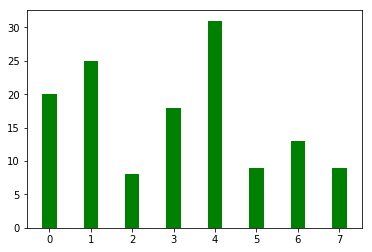

In [34]:
plt.bar(cu, cnt, width =0.35, color='g')
plt.show()

In [35]:
nx.set_node_attributes(G, partition, 'group')

visualize(G)

changing directory to /Users/Anna/.netwulf
starting server here ... /Users/Anna/.netwulf


127.0.0.1 - - [22/May/2019 18:37:05] "GET /?data=tmp_16ae0674111.json&config=config_tmp_16ae0674111.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:05] "GET /config_tmp_16ae0674111.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:05] "GET /tmp_16ae0674111.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:05] code 404, message File not found
127.0.0.1 - - [22/May/2019 18:37:05] "GET /favicon.ico HTTP/1.1" 404 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to /Users/Anna/Documents/GitHub/a3B/Exam Project


### Political Party Communities

In [36]:
parti_group = dict(zip(info_rt.User_Name, info_rt.Parti_farve))
len(parti_group)

133

In [37]:
nx.set_node_attributes(G, parti_group, 'group')

config = visualize(G)

changing directory to /Users/Anna/.netwulf
starting server here ... /Users/Anna/.netwulf


127.0.0.1 - - [22/May/2019 18:37:16] "GET /?data=tmp_16ae0676f32.json&config=config_tmp_16ae0676f32.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:16] "GET /config_tmp_16ae0676f32.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:17] "GET /tmp_16ae0676f32.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:17] code 404, message File not found
127.0.0.1 - - [22/May/2019 18:37:17] "GET /favicon.ico HTTP/1.1" 404 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to /Users/Anna/Documents/GitHub/a3B/Exam Project


### Degree Distribution

Text(0.5,0,'Degree')

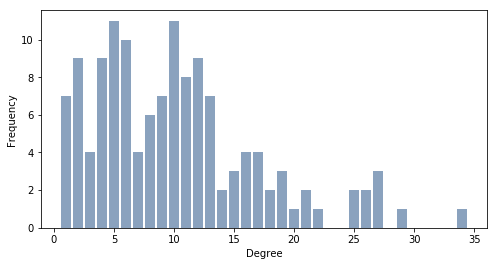

In [38]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

figure(figsize=(8,4))
plt.bar(deg, cnt, width=0.80, color=('#8AA2BE'))
#plt.title('Degree Histrogram')
plt.ylabel('Frequency')
plt.xlabel('Degree')

### Centrality

In [39]:
centrality = nx.betweenness_centrality(G, weight='weight')
centrality = pd.DataFrame.from_dict(centrality, orient='index')
top_10 = centrality.sort_values(by=[0], ascending=False).head(10)
top_10_list = top_10.index.tolist()

In [40]:
info_10 = pd.DataFrame(info_rt.User_Name)
info_10['Color'] = 'grey'

#info_10.loc[info_10['User_Name'] == 'pia_kjaersgaard', 'Color'] = 'red'

for i in range(len(top_10_list)):
    info_10.loc[info_10['User_Name'] == top_10_list[i], 'Color'] = '#b23b3e'

In [41]:
top_group = dict(zip(info_10.User_Name, info_10.Color))

nx.set_node_attributes(G, top_group, 'group')
config = visualize(G)

changing directory to /Users/Anna/.netwulf
starting server here ... /Users/Anna/.netwulf


127.0.0.1 - - [22/May/2019 18:37:30] "GET /?data=tmp_16ae067a603.json&config=config_tmp_16ae067a603.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:30] "GET /config_tmp_16ae067a603.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:31] "GET /tmp_16ae067a603.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:37:31] code 404, message File not found
127.0.0.1 - - [22/May/2019 18:37:31] "GET /favicon.ico HTTP/1.1" 404 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to /Users/Anna/Documents/GitHub/a3B/Exam Project


### Clustering Coefficients

In [42]:
clusters_ = nx.clustering(G)

Text(0,0.5,'Frequency')

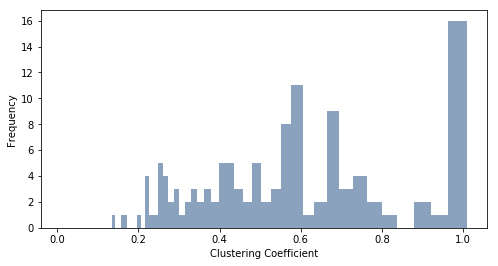

In [43]:
figure(figsize=(8,4))
bins=np.logspace(np.log10(0.01),np.log10(1.01), 100)
plt.hist(clusters_.values(), bins, color=('#8AA2BE'))
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')

In [44]:
avg_cluster = nx.average_clustering(G)
avg_cluster

0.5047129330282245

## ReTweet Network with annotations

In [45]:
#read data
df = pd.read_csv('data.csv')
df['User_Name']=df['User_Name'].str.lower()    
df['Link_1']=df['Link_1'].str.lower()    
df['Message']=df['Message'].str.lower()   


# We only need retweets (WithContent)
df_B=df[(df.Retweet_WC == 1)]
#df_B['User_Name']=df_B['User_Name'].str.lower()

### Prepare data for Network Analysis

In [46]:
# Use regex to find account retweetet from
def rt_account(temp):
    temp = re.findall(r'https://twitter.com/(\w+)', temp)
    return temp
rt_account('https://twitter.com/fb_feriehuse/status/111')
df_B['retweet_from'] = df_B.Link_1.apply(lambda x: rt_account(x)[0]).str.lower()



/Users/Anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
#List with unique politicians (Of all tweets)
politiciansB=pd.DataFrame(df.User_Name.unique())


# # Add dummy indicating if the profile retweetet from is a poliician
politiciansB['Politicians'] = 1
politiciansB['rt_account']=politiciansB[0].str.lower()

politiciansB.head()

,0,Politicians,rt_account
0,hans_kr_skibby,1,hans_kr_skibby
1,metteabildgaard,1,metteabildgaard
2,liberalalliance,1,liberalalliance
3,uffeelbaek,1,uffeelbaek
4,anehalsboe,1,anehalsboe


In [48]:
#Adds dummy to data set
df_B = df_B.merge(politiciansB, how='left' ,left_on= 'retweet_from', right_on ='rt_account')

# We only want tweets, where the  the profile retweetet from is a politicians
df_B=df_B[(df_B.Politicians == 1)]
# (408, 29) Comments from politicians - Before: (1685, 26)

In [49]:
#Keep only relevant columns
df_B = df_B[['User_Name','retweet_from', 'Blok', 'Parti', 'Parti_tal','Parti_farve']]

In [50]:
#Get unique names from the column with those re-tweeted
tweeters_B = df_B[['User_Name', 'Blok', 'Parti', 'Parti_tal', 'Parti_farve']].drop_duplicates()

#Get unique names from the column with those who has been re-tweeted
re_uniques_B = df_B[['retweet_from']].drop_duplicates()


#df_unique = df[['User_Name', 'Blok', 'Parti', 'Parti_tal', 'Parti_farve']].drop_duplicates()
#add their information from the full sampled data
re_tweeted_B = re_uniques_B.merge(df[['User_Name', 'Blok', 'Parti', 'Parti_tal', 'Parti_farve']], how='left' ,left_on= 'retweet_from', right_on ='User_Name')


info_rt_B = tweeters_B.append(re_tweeted_B)
info_rt_B = info_rt_B[['User_Name', 'Blok', 'Parti', 'Parti_tal', 'Parti_farve']].drop_duplicates()

/Users/Anna/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


### NODES

In [51]:
#List with unique politicians (Of all retweets, retweetet from a politician)
nodes_B=df_B[['User_Name', 'Blok', 'Parti', 'Parti_tal']].drop_duplicates()
print(nodes_B.shape)
type(nodes_B)

(91, 4)


pandas.core.frame.DataFrame

### EDGES

In [52]:
#Count number of unique combinations, in the 'weight' column.
edges_B = df_B.groupby(['User_Name','retweet_from']).size().reset_index(name='weight')
edges_B.head()

,User_Name,retweet_from,weight
0,adsboladsbl,jakobsoelvhoej,1
1,adsboladsbl,jthulesen,1
2,adsboladsbl,kristensenberth,1
3,adsboladsbl,pia_kjaersgaard,2
4,anderssamuelsen,liberalalliance,1


### Create a NetworkX

In [65]:
G_B = nx.from_pandas_edgelist(edges_B, 'User_Name', 'retweet_from', 'weight')

print(nx.info(G_B))

Name: 
Type: Graph
Number of nodes: 114
Number of edges: 295
Average degree:   5.1754


### Community Partition

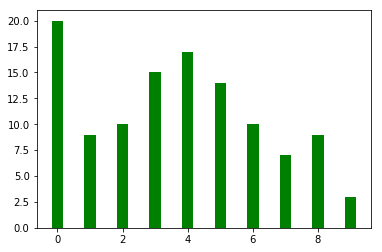

In [54]:
partition_B = community.best_partition(G_B)
communi_seq_B=partition_B.values()
communi_count_B=collections.Counter(communi_seq_B)
cu_B, cnt_B =zip(*communi_count_B.items())

plt.bar(cu_B, cnt_B, width =0.35, color='g')
plt.show()

In [55]:
nx.set_node_attributes(G_B, partition_B, 'group')

visualize(G_B)

changing directory to /Users/Anna/.netwulf
starting server here ... /Users/Anna/.netwulf


127.0.0.1 - - [22/May/2019 18:38:12] "GET /?data=tmp_16ae06848e7.json&config=config_tmp_16ae06848e7.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:12] "GET /config_tmp_16ae06848e7.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:12] "GET /tmp_16ae06848e7.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:12] code 404, message File not found
127.0.0.1 - - [22/May/2019 18:38:12] "GET /favicon.ico HTTP/1.1" 404 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to /Users/Anna/Documents/GitHub/a3B/Exam Project


### Party Communities

In [56]:
parti_group_B = dict(zip(info_rt_B.User_Name, info_rt_B.Parti_farve))

In [57]:
nx.set_node_attributes(G_B, parti_group_B, 'group')
visualize(G_B)


changing directory to /Users/Anna/.netwulf
starting server here ... /Users/Anna/.netwulf


127.0.0.1 - - [22/May/2019 18:38:28] "GET /?data=tmp_16ae06885ac.json&config=config_tmp_16ae06885ac.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:28] "GET /config_tmp_16ae06885ac.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:28] "GET /tmp_16ae06885ac.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:28] code 404, message File not found
127.0.0.1 - - [22/May/2019 18:38:28] "GET /favicon.ico HTTP/1.1" 404 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to /Users/Anna/Documents/GitHub/a3B/Exam Project


### Degree Distribution

Text(0.5,0,'Degree')

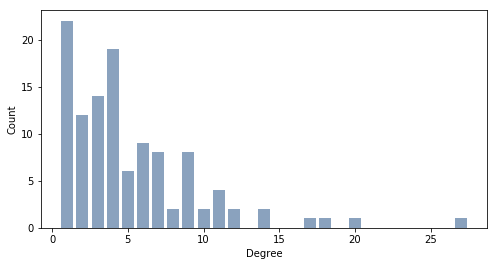

In [64]:
figure(figsize=(8,4))
degree_sequence_B = sorted([d for n, d in G_B.degree()], reverse=True)
degree_count_B = collections.Counter(degree_sequence_B)
deg_B, cnt_B = zip(*degree_count_B.items())

plt.bar(deg_B, cnt_B, width=0.80, color=('#8AA2BE'))
plt.ylabel('Frequency')
plt.xlabel('Degree')

### Clustering Coefficient

In [68]:
clusters_B = nx.clustering(G_B)

In [69]:
avg_cluster_B = nx.average_clustering(G_B)
avg_cluster_B

0.1193643811755267

Text(0,0.5,'Frequency')

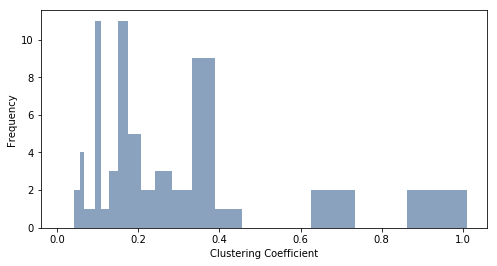

In [70]:
figure(figsize=(8,4))
bins=np.logspace(np.log10(0.01),np.log10(1.01), 30)
plt.hist(clusters_B.values(), bins, color=('#8AA2BE'))

plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')

### Centraliy

In [61]:
### Centrality

centrality_B = nx.betweenness_centrality(G_B, weight='weight')
centrality_B = pd.DataFrame.from_dict(centrality_B, orient='index')
top_10_B = centrality_B.sort_values(by=[0], ascending=False).head(10)
top_10_list_B = top_10_B.index.tolist()

info_10_B = pd.DataFrame(info_rt_B.User_Name)
info_10_B['Color'] = 'grey'

#info_10.loc[info_10['User_Name'] == 'pia_kjaersgaard', 'Color'] = 'red'

for i in range(len(top_10_list_B)):
    info_10_B.loc[info_10_B['User_Name'] == top_10_list_B[i], 'Color'] = '#b23b3e'

top_group_B = dict(zip(info_10_B.User_Name, info_10_B.Color))

changing directory to /Users/Anna/.netwulf
starting server here ... /Users/Anna/.netwulf


127.0.0.1 - - [22/May/2019 18:38:44] "GET /?data=tmp_16ae068c413.json&config=config_tmp_16ae068c413.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:44] "GET /config_tmp_16ae068c413.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:44] "GET /tmp_16ae068c413.json HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2019 18:38:44] code 404, message File not found
127.0.0.1 - - [22/May/2019 18:38:44] "GET /favicon.ico HTTP/1.1" 404 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to /Users/Anna/Documents/GitHub/a3B/Exam Project


In [ ]:
nx.set_node_attributes(G_B, top_group_B, 'group')
visualize(G_B)

# 6_BigramsNetwork

In [2]:
#indlæs data
df = pd.read_csv('translated.csv', index_col=[0])

In [3]:
# lav om på engelsk
# Lowercase, fjerner tegn, tal, og opdeler alle ord.

def step3(temp):
    temp = temp.lower()
    temp = re.sub(r'[^\w\s]','', temp)
    temp = re.sub('__rt__', '', temp)
    temp = re.sub('__profile__', '', temp)
    temp = re.sub('__time__', '', temp)
    temp = re.sub('__link__', '', temp)
    temp = re.sub('__ending__', '', temp)
    temp = re.sub('__emoji__', '', temp)
    temp = re.sub('__email__', '', temp)
    temp = re.sub(r'\d', "", temp)
    temp = temp.split()
    return temp


df['lang_clean'] = df.oversat.apply(lambda x: step3(x))

In [4]:
print(df.oversat.iloc[8])
print(df.lang_clean.iloc[8])

__RT__ I look forward to celebrating the Danish Maritimes 100 year anniversary tomorrow at the National Museum. We need to hear __profile__ __profile__
['i', 'look', 'forward', 'to', 'celebrating', 'the', 'danish', 'maritimes', 'year', 'anniversary', 'tomorrow', 'at', 'the', 'national', 'museum', 'we', 'need', 'to', 'hear']


In [5]:
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words

stop_words = list(stopwords.words('english'))    #About 150 stopwords
nltk_words = list(get_stop_words('en'))         #About 900 stopwords
stop_words.extend(nltk_words)

df['lang_reduced'] = df.lang_clean.apply(lambda x: [item for item in x if item not in stop_words])

In [7]:
df[['Message', 'lang_reduced']].to_csv('en_short_text.csv', index=False, sep = ',')

In [8]:
terms_bigrams =[list(bigrams(tweet)) for tweet in df.lang_reduced]

In [10]:
bigram = list(itertools.chain(*terms_bigrams))

bigram_count = collections.Counter(bigram)

In [11]:
bigram_df =pd.DataFrame(bigram_count.most_common(170),columns=['bigram', 'count'])

In [12]:
d = bigram_df.set_index('bigram').T.to_dict('records')

In [13]:
from_ = []
to_= []
w = []
for k, v in d[0].items():
    from_.append(k[0])
    to_.append(k[1])
    w.append(v)

len(w)

170

In [14]:
df=pd.DataFrame(from_,columns=['from'])
df['to'] = pd.DataFrame(to_,index=df.index)
df['weight'] = pd.DataFrame(w,index=df.index)
#edges['color'] = 'grey'

In [15]:
G_1 = nx.from_pandas_edgelist(df, 'from', 'to', 'weight')

In [16]:
partition = community.best_partition(G_1)

In [17]:
nx.set_node_attributes(G_1, partition, 'group')

In [18]:
from netwulf import visualize
visualize(G_1)

changing directory to /Users/Anna/.netwulf
starting server here ... /Users/Anna/.netwulf


127.0.0.1 - - [23/May/2019 23:14:04] "GET /?data=tmp_16ae68b3483.json&config=config_tmp_16ae68b3483.json HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2019 23:14:04] "GET /libs/lodash.js HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2019 23:14:04] "GET /config_tmp_16ae68b3483.json HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2019 23:14:04] "GET /tmp_16ae68b3483.json HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2019 23:14:05] code 404, message File not found
127.0.0.1 - - [23/May/2019 23:14:05] "GET /favicon.ico HTTP/1.1" 404 -


stopping server ...
was asked to stop the server
deleted all files
changing directory back to /Users/Anna/Documents/GitHub/a3B/Exam Project


# 7_Sentiment

In [5]:
# reading translated.csv
df = pd.read_csv('translated.csv', index_col=[0])
#df

In [6]:
# using Vader to create a sentiment score for every tweet
analyser = SentimentIntensityAnalyzer()
def sentiment_score(temp):
    temp = analyser.polarity_scores(temp)
    return temp
df['sentiment_score_neg'] = df.oversat.apply(lambda x: sentiment_score(x)['neg'])
df['sentiment_score_neu'] = df.oversat.apply(lambda x: sentiment_score(x)['neu'])
df['sentiment_score_pos'] = df.oversat.apply(lambda x: sentiment_score(x)['pos'])
df['sentiment_score_compound'] = df.oversat.apply(lambda x: sentiment_score(x)['compound'])
#Sentiment_score("love")
#df

In [7]:
# fixer fejl med "blue "
df.loc[df['Blok'] == 'blue ', 'Blok'] = 'blue'

In [8]:
# saving sentimented.csv
#df.to_csv('sentimented.csv')

# reading translated.csv
df = pd.read_csv('sentimented.csv', index_col=[0])
df.oversat = df.oversat.str.lower()

## plots

0.19654655172413796


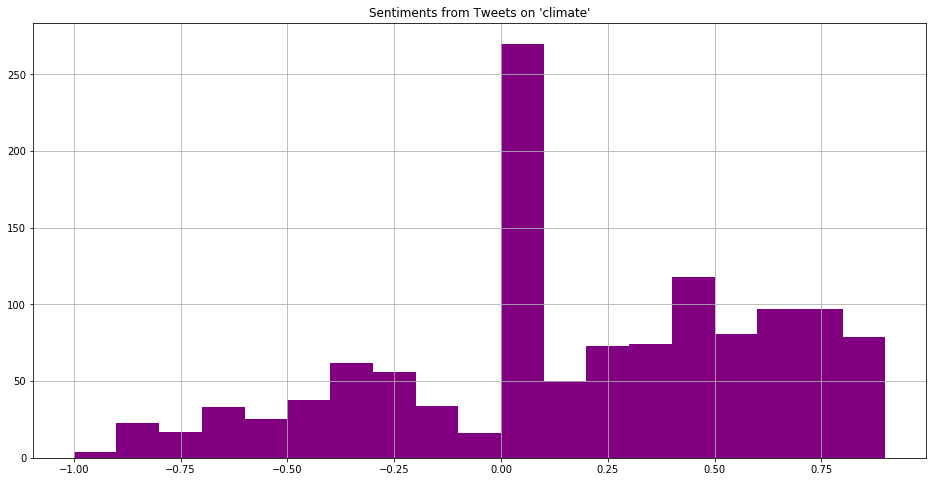

In [138]:
# climate bitches
#df_climate = df.oversat.str.contains('climate')
#df_climate = df[df_climate == True]
#df_climate = df_climate.sentiment_score_compound
#print(df_climate.mean())
#fig, ax = plt.subplots(figsize=(16,8))
#df_climate.hist(bins=np.arange(-1,1,1/10),
#             ax=ax,
#             color="purple")
#plt.title("Sentiments from Tweets on 'climate'")
#plt.show()

In [123]:
df_red = df[df.Blok == 'red']
df_blue = df[df.Blok == 'blue']

0.16648605817452358
997


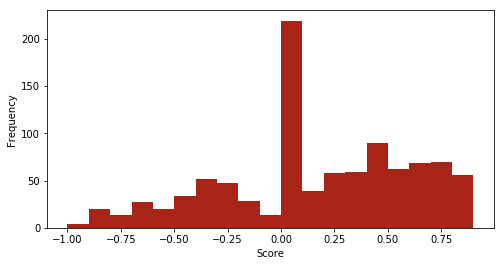

0.30396702508960577
279


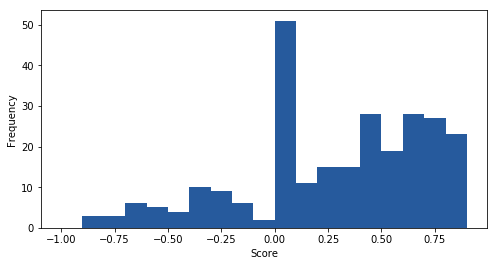

In [155]:
# climate red
df_plot = df_red.oversat.str.contains('climate')
df_plot = df_red[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#A82417")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

# climate blue
df_plot = df_blue.oversat.str.contains('climate')
df_plot = df_blue[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#265A9D")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

-0.01795857142857144
70


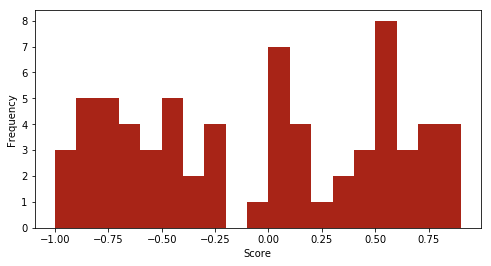

-0.22208823529411761
68


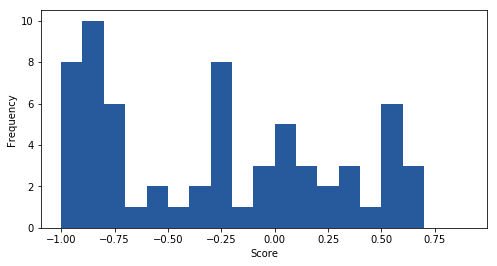

In [156]:
# paludan red
df_plot = df_red.oversat.str.contains('paludan')
df_plot = df_red[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#A82417")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

# paludan blue
df_plot = df_blue.oversat.str.contains('paludan')
df_plot = df_blue[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#265A9D")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

0.1841931747673216
967


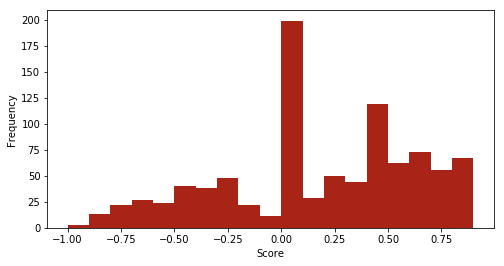

0.23833743500866553
577


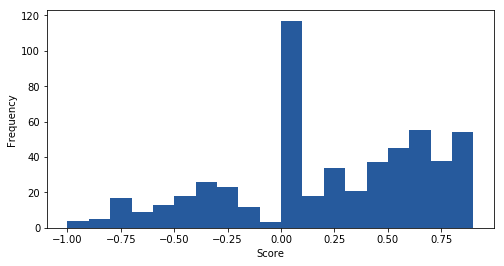

In [158]:
# eu red
df_plot = df_red.oversat.str.contains('eu')
df_plot = df_red[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#A82417")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

# eu blue
df_plot = df_blue.oversat.str.contains('eu')
df_plot = df_blue[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#265A9D")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

In [ ]:
# eu red
df_plot = df_red.oversat.str.contains('health')
df_plot = df_red[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#A82417")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

# eu blue
df_plot = df_blue.oversat.str.contains('health')
df_plot = df_blue[df_plot == True]
df_plot = df_plot.sentiment_score_compound
print(df_plot.mean())
print(df_plot.count())
fig, ax = plt.subplots(figsize=(8,4))
df_plot.hist(bins=np.arange(-1,1,1/10),
             ax=ax,
             color="#265A9D")
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.grid(False)
plt.show()

In [22]:
# parti comparison
df.groupby(['Parti']).mean().iloc[:,[-4,-3,-2,-1]].round(2)

,sentiment_score_neg,sentiment_score_neu,sentiment_score_pos,sentiment_score_compound
Parti,,,,
A,0.06,0.82,0.12,0.15
B,0.05,0.82,0.13,0.20
C,0.06,0.81,0.13,0.16
F,0.05,0.82,0.13,0.17
I,0.06,0.82,0.12,0.16
O,0.07,0.82,0.11,0.10
V,0.04,0.83,0.13,0.24
Å,0.05,0.84,0.10,0.14
Ø,0.07,0.83,0.10,0.10


In [10]:
# blue vs. red comparison
df.groupby(['Blok']).mean()

,Followers,Likes,Retweets,Score,Parti_tal,Account_Type,Retweet,text_len,text_sum,sentiment_score_neg,sentiment_score_neu,sentiment_score_pos,sentiment_score_compound
Blok,,,,,,,,,,,,,
blue,18410.840637,86.158769,20.194282,-14.793793,4.487387,0.044614,0.289841,148.899199,1.846128e+06,0.057858,0.821717,0.120420,0.170407
red,20519.600778,318.295577,90.654791,-2.964767,4.442506,0.066830,0.386425,152.400676,2.084975e+06,0.058687,0.826017,0.115296,0.146130


# 8_prediction

In [5]:
data = pd.read_csv('sentimented.csv', index_col=[0])
data_to_merge = pd.read_csv('data.csv', index_col=[0])
df = pd.merge(data,data_to_merge[['Message', 'Retweet_WOC', 'Comment', 'Retweet_WC']],on='Message', how='left')
data_text = pd.read_csv('en_short_text.csv', index_col=[0])
df = pd.merge(df, data_text, on='Message', how='left')
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [6]:
df = df.drop(['Account', 'User_Name', 'Type', 
         'URL', 'Message', 'Screen_Name', 
         'Link_1', 'Final_Link_1', 'Link_2',
         'Final_Link_2', 'Score', 'Navn', 
         'Parti_tal', 'Account_Type', 'Ymd', 
         'Msgfrst2', 'Retweet', 'test', 'text', 
         'text_sum', 'sentiment_score_neg', 
         'sentiment_score_neu', 'sentiment_score_pos','Message', 'oversat','Blok'], axis=1)

In [7]:
df['Date_new'] = pd.to_datetime(df.Date.str.strip(), format = '%Y-%m-%d %H:%M:%S')

# hour
df['hour'] = df['Date_new'].dt.hour
#hour_ = pd.get_dummies(df.hour)
#df = pd.concat([df, hour_], axis=1)

# weekday
df['weekday'] = df['Date_new'].dt.strftime('%A')
weekday_ = pd.get_dummies(df.weekday)
df = pd.concat([df, weekday_], axis=1)

# drop it like its hot
df = df.drop(['weekday', 'Date_new', 'Date'], axis=1)


In [8]:
time_of_day = []
for i in range(len(df)):
    if 6>df.hour[i]>=0 and df.hour[i]<6:
        time_of_day.append('Night')
    else:
        if 12>df.hour[i]>=6 and df.hour[i]:
            time_of_day.append('Morning')
        else:
            if 18>df.hour[i]>=12:
                time_of_day.append('Midday')
            else:
                if 23>=df.hour[i]>=18:
                    time_of_day.append('Evening')

#Time of the day
time_day = pd.get_dummies(time_of_day)
df = pd.concat([df, time_day], axis=1)
df = df.drop(['hour'], axis=1)

In [9]:
#blok_ = pd.get_dummies(df.Blok)
#df = pd.concat([df, blok_], axis=1)

parti_ = pd.get_dummies(df.Parti)
df = pd.concat([df, parti_], axis=1)


df = df.drop(['Parti'], axis=1)

In [10]:
# Create a dummy for re-tweets with comments
Tweet = []
count_ = 0
for i in range(len(df)):

    if  df['Retweet_WC'][i] ==0 and df['Retweet_WOC'][i] ==0 and df['Comment'][i] ==0:
        count_ = count_ + 1
        Tweet.append(1)
            
    else:
        Tweet.append(0)

df['Tweet'] = pd.DataFrame(Tweet, index=df.index)
df = df[df['Tweet'] == 1]
df = df.drop(['Comment', 'Retweet_WOC', 'Retweet_WC'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Tweet'], axis=1)

In [11]:
#Convert from string to list for look-up
def string_to_list(temp):
    temp = re.sub("[^\w]", " ", temp).split()
    return temp

df['Text'] = df['lang_reduced'].apply(lambda x: string_to_list(x))
df = df.drop(['lang_reduced'], axis=1)

In [12]:
climate_ = []
health_ =[]
children_ = []
tax_ = []
work_ = []
eu_ = []
school_ = []
election_ = []
retirement_ = []
welfare_ = []


for i in range(len(df)):
    if 'climate' in df['Text'][i]:
        climate_.append(1)
    else:
        climate_.append(0)


for i in range(len(df)):
    if 'health' in df['Text'][i]:
        health_.append(1)
    else:
        health_.append(0)
        
for i in range(len(df)):
    if 'children' in df['Text'][i]:
        children_.append(1)
    else:
        children_.append(0)
        
for i in range(len(df)):
    if 'tax' in df['Text'][i]:
        tax_.append(1)
    else:
        tax_.append(0)

for i in range(len(df)):
    if 'work' in df['Text'][i]:
        work_.append(1)
    else:
        work_.append(0)

for i in range(len(df)):
    if 'eu' in df['Text'][i]:
        eu_.append(1)
    else:
        eu_.append(0)

for i in range(len(df)):
    if 'school' in df['Text'][i]:
        school_.append(1)
    else:
        school_.append(0)

for i in range(len(df)):
    if 'election' in df['Text'][i]:
        election_.append(1)
    else:
        election_.append(0)

for i in range(len(df)):
    if 'retirement' in df['Text'][i]:
        retirement_.append(1)
    else:
        retirement_.append(0)

for i in range(len(df)):
    if 'welfare' in df['Text'][i]:
        welfare_.append(1)
    else:
        welfare_.append(0)

df['Climate'] = pd.DataFrame(climate_, index=df.index)
df['Health'] = pd.DataFrame(health_, index=df.index)
df['Children'] = pd.DataFrame(children_, index=df.index)
df['Tax'] = pd.DataFrame(tax_, index=df.index)
df['Work'] = pd.DataFrame(work_, index=df.index)
df['EU'] = pd.DataFrame(eu_, index=df.index)
df['School'] = pd.DataFrame(school_, index=df.index)
df['Election'] = pd.DataFrame(election_, index=df.index)
df['Retirement'] = pd.DataFrame(retirement_, index=df.index)
df['Welfare'] = pd.DataFrame(welfare_, index=df.index)

df = df.drop(['Text'], axis=1)
#count_

In [13]:
df.to_csv('predict_data.csv')

## Random Forest

In [33]:
# reading
df = pd.read_csv('predict_data.csv', index_col=([0]))

# fixing
df = df.fillna(0)

# X & y
X = df.drop(['Likes'], axis=1)
X_col = X.keys()
y = df.Likes
X = np.array(X)
y = np.array(y)

# splitting into development (2/3) and test data (1/3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=1)

In [42]:
number_esti =  range(1,200,5)
depth = range(1,10,1)

pipe_randforest = make_pipeline(RandomForestRegressor(random_state=1)) 

gs = GridSearchCV(estimator=pipe_randforest, 
                  param_grid=[{'randomforestregressor__n_estimators':number_esti, 
                               'randomforestregressor__max_depth':depth}], #Now two hyperparameters
                  scoring='neg_mean_squared_error', 
                  cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)
gs.best_params_


rand_forest_number=gs.best_params_.get('randomforestregressor__n_estimators')
rand_forest_depth=gs.best_params_.get('randomforestregressor__max_depth')

pipe_randforest_final = make_pipeline(RandomForestRegressor(random_state=1, n_estimators=rand_forest_number,max_depth=rand_forest_depth))
pipe_randforest_final.fit(X_train, y_train)

# mse
mseCVforest_train=mse(y_train,pipe_randforest_final.predict(X_train))
mseCVforest_test=mse(y_test,pipe_randforest_final.predict(X_test))



/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [56]:
print(round(mseCVforest_train,2))
print(round(mseCVforest_test,2))
print(gs.best_params_)

3473.8
8836.17
{'randomforestregressor__max_depth': 5, 'randomforestregressor__n_estimators': 6}


In [58]:
forest = RandomForestRegressor(n_estimators=6,max_depth=5,criterion='mse',random_state=1,n_jobs=-1) #n_estimators=1000,criterion='mse',random_state=1,max_depth=10,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('Train MSE: '+ str(mse(y_train,y_train_pred)))
print('Test MSE: '+ str(mse(y_test,y_test_pred)))


Train MSE: 3473.804517560492
Test MSE: 8836.166545264963


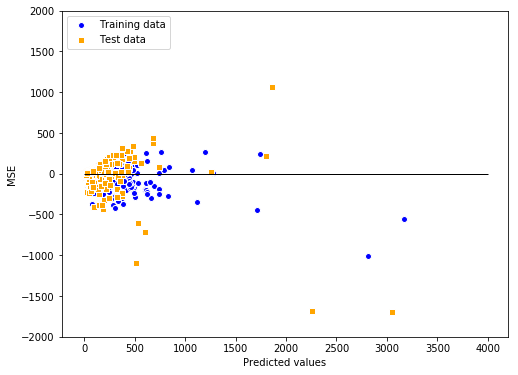

In [45]:
figure(figsize = (8,6))

plt.scatter(y_train_pred, y_train_pred - y_train,
            label = 'Training data',
            c = 'blue',
            marker = 'o',
            edgecolor = 'white')

plt.scatter(y_test_pred, y_test_pred - y_test,
            label = 'Test data',
            c = 'orange',
            marker = 's',
            edgecolor = 'white')

plt.xlabel('Predicted values')
plt.ylabel('MSE')
plt.legend(loc = 'upper left')
plt.hlines(y=0, xmin = 0, xmax=4000, color = 'black', lw = 1)
plt.ylim([-2000,2000])
plt.show()

Text(0,0.5,'MSE')

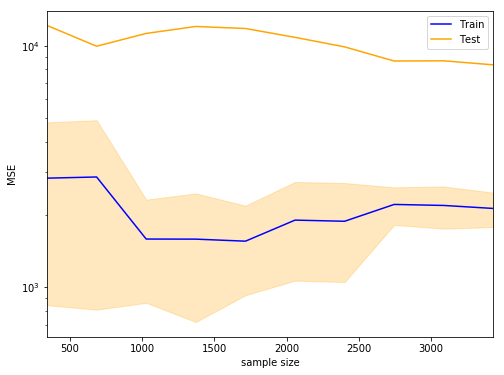

In [46]:
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=forest,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10), #array from 0.1  to 1, share of observations used
                   scoring='neg_mean_squared_error',  #Turns from min prob to max prob.                
                   cv=5) #Crossvalidation steps
    
#minus again, reverts
mse_forrest = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))  

# learn motherfucker
f_learn, ax = plt.subplots(figsize=(8,6))
mse_forrest.plot(ax=ax, logy=True, color=['blue','orange'])
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('MSE')


In [47]:
# validation curve

# Create range of values for parameter
param_range = np.arange(1, 50, 1)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X, 
                                             y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


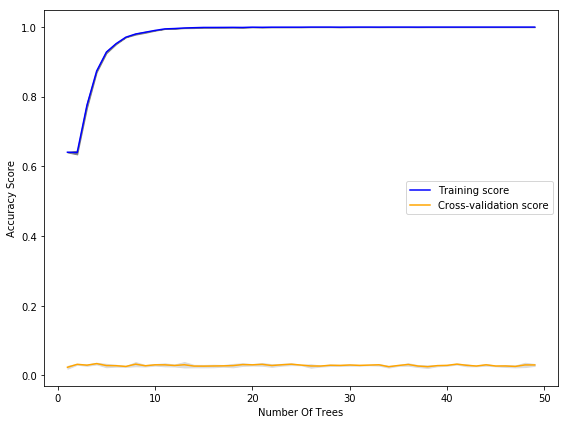

In [48]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
figure(figsize = (8,6))
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
#plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [49]:
forest=RandomForestRegressor(random_state=1, n_estimators=rand_forest_number,max_depth=rand_forest_depth)
forest.fit(X_train,y_train)
importance = forest.feature_importances_.tolist()

df_FI = pd.DataFrame({'importances': importance,'features': X_col})
df_FI = df_FI.groupby(['importances']).sum().reset_index()
df_FI = df_FI.sort_values(by = 'importances', ascending = False)

importance = df_FI['importances'].tolist()
features = df_FI['features'].tolist()

In [50]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

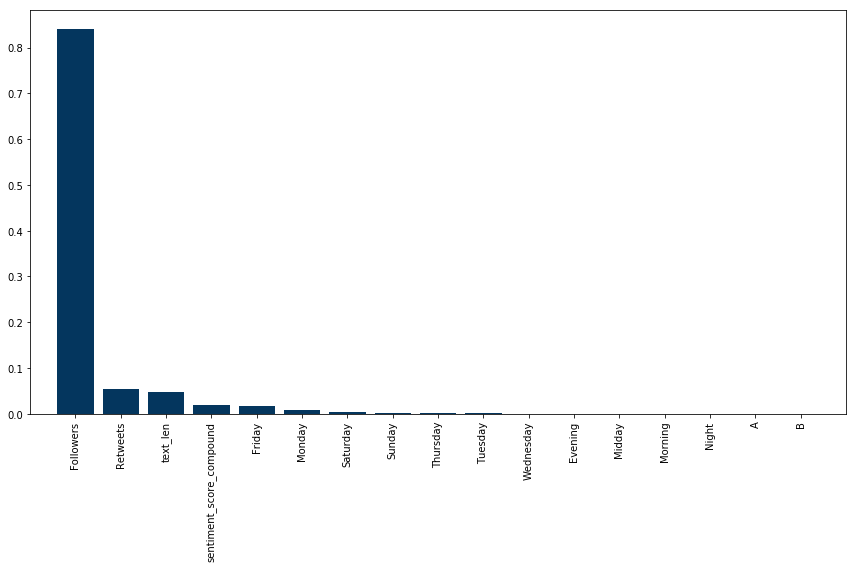

In [52]:
figure(figsize = (12,8))
#plt.title('Feature Importances')
plt.bar(range(len(features)), importance, color='#04365E', align='center')
plt.xticks(range(len(features)), X_col, rotation=90)
plt.xlim([-1, len(features)])
plt.tight_layout()
plt.show()

In [53]:
importance[0]/importance[1]

15.26144023500447

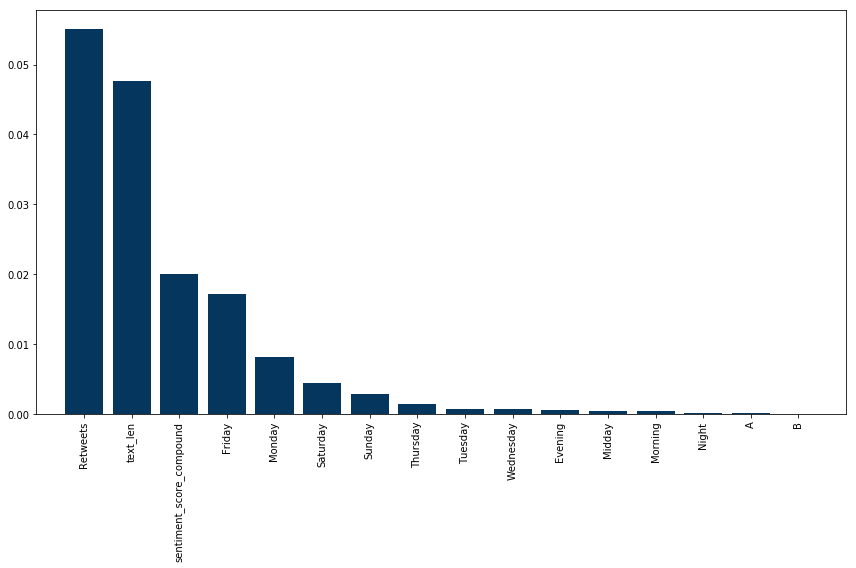

In [54]:
figure(figsize = (12,8))
#plt.title('Feature Importances')
plt.bar(range(len(features)-1), importance[1:], color='#04365E', align='center')
plt.xticks(range(len(features)-1), X_col[1:], rotation=90)
plt.xlim([-1, len(features)-1])
plt.tight_layout()
plt.show()